### **Configuration**

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

## **Multi-Head Attention**

In [2]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
    super().__init__()
    assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
    self.d_in = d_in
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_Query = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_Key = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_Value = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        "mask",
        torch.tril(torch.ones(context_length, context_length), diagonal = 1))

  def forward(self, x):
    b, num_tokens, d_in = x.shape

    keys = self.W_Key(x)
    queries = self.W_Query(x)
    values = self.W_Value(x)

    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)
    queries = queries.transpose(1, 2)

    attn_scores = queries @ keys.transpose(2, 3)

    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

    attn_scores.masked_fill_(mask_bool, float("-inf"))

    attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim = -1)
    attn_weights = self.dropout(attn_weights)

    context_vec = (attn_weights @ values).transpose(1, 2)

    # Combine heads, where self.d_out = self.num_heads * self.head_dim
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
    context_vec = self.out_proj(context_vec)

    return context_vec

## **Layer Norm**

In [3]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased = False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

## **GeLU Activation**

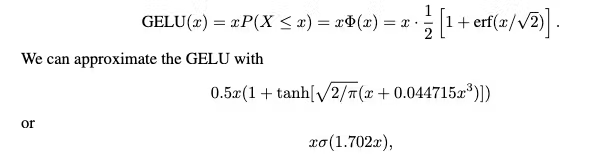

In [9]:
class GeLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
         (x + 0.044715 * torch.pow(x, 3))
         ))

In [10]:
x = torch.linspace(-3, 3, 100)

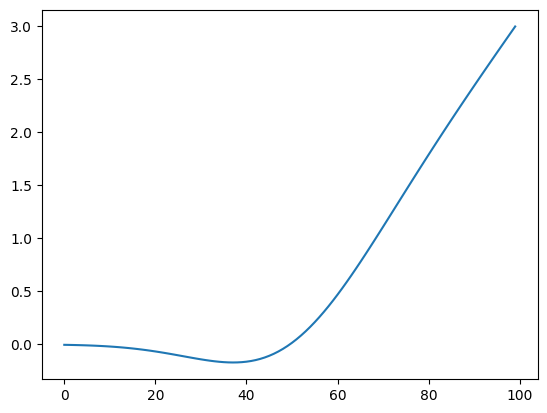

In [12]:
gelu = GeLU()
import matplotlib.pyplot as plt
plt.plot(gelu(x))

## **Feed Forward**

In [13]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GeLU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self, x):
    return self.layers(x)

In [14]:
ffn = FeedForward(GPT_CONFIG_124M)

In [15]:
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## **LLM Transformer Block**

In [16]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [18]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attn = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"]
    )
    self.ffn = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    # Shortcut connection for attention block
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x) # Shape [batch_size, num_tokens, emb_size]
    x = self.drop_shortcut(x)
    x = x + shortcut # Add original input back

    # Shortcut connection for FeedForward block
    shortcut = x
    x = self.norm2(x)
    x = self.ffn(x) # Shape [batch_size, num_tokens, emb_size]
    x = self.drop_shortcut(x)
    x = x + shortcut # Add original input back

    return x

In [19]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [23]:
!pip install torchinfo
from torchinfo import summary
summary(block)

Layer (type:depth-idx)                   Param #
TransformerBlock                         --
├─MultiHeadAttention: 1-1                --
│    └─Linear: 2-1                       589,824
│    └─Linear: 2-2                       589,824
│    └─Linear: 2-3                       589,824
│    └─Linear: 2-4                       590,592
│    └─Dropout: 2-5                      --
├─FeedForward: 1-2                       --
│    └─Sequential: 2-6                   --
│    │    └─Linear: 3-1                  2,362,368
│    │    └─GeLU: 3-2                    --
│    │    └─Linear: 3-3                  2,360,064
├─LayerNorm: 1-3                         1,536
├─LayerNorm: 1-4                         1,536
├─Dropout: 1-5                           --
Total params: 7,085,568
Trainable params: 7,085,568
Non-trainable params: 0